In [1]:
import os
from importlib.resources import files
import time

import numpy as np
import torch
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

from fastdtw import fastdtw
# from scipy.spatial.distance import cosine
# from sklearn.metrics.pairwise import cosine_similarity
from learn_embedding.utils.soft_dtw_cuda import SoftDTW

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry
from learn_embedding.utils import *
from learn_embedding.loss import *

In [2]:
dim = 2
num_traj = 7  # Number of trajectories
num_samples = 1000  # Desired number of samples per trajectory
split = int(np.round(num_traj*0.6))
first_order = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
data_x = []
data_y = []

for i in range(1, num_traj+1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/toycase/trajectory_" + str(i) + ".csv")
    
    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)
    data[idx,:2] -= data[-1,:2]
    data[-1,2:4] = np.zeros(2)
    data[-1,-2:] = np.zeros(2)
    
    # add to datset
    data_x.append(data[idx,:2]  if first_order else data[idx,:4])
    data_y.append(data[idx,2:4] if first_order else data[idx,-2:])

In [4]:
reps = 10
num_neurons = [64]
num_layers = 2

cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
sdtw = SoftDTW(use_cuda=use_cuda, gamma=0.01)

rmse_log = torch.zeros(reps).to(device)
cos_log = torch.zeros(reps).to(device)
dtw_log = torch.zeros(reps).to(device)

for k in range(reps):
    idx = np.random.permutation(num_traj)
    
    train_x = np.empty((0, 2)) if first_order else np.empty((0, 4))
    train_y = np.empty((0, 2))
    
    for i in idx[:split]:
        train_x = np.append(train_x, data_x[i], axis=0)
        train_y = np.append(train_y, data_y[i], axis=0)
        
    train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
    train_y = torch.from_numpy(train_y).float().to(device)

    if first_order:
        model = FirstGeometry(Embedding(FeedForward(dim, num_neurons*num_layers, 1)), torch.tensor([0,0]).to(device), SPD(dim)).to(device)
    else:
        model = SecondGeometry(Embedding(FeedForward(dim, num_neurons*num_layers, 1)), torch.tensor([0,0]).to(device), SPD(dim), SPD(dim)).to(device)

    trainer = Trainer(model, train_x, train_y)

    trainer.optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    # trainer.optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2, weight_decay=1e-1)

    trainer.loss = torch.nn.MSELoss()
    # trainer.loss = torch.nn.SmoothL1Loss()

    trainer.options(normalize=False, shuffle=True, print_loss=False,epochs=100)
    trainer.train()
    
    for i in idx[split:]:
        test_x = torch.from_numpy(data_x[i]).float().to(device).requires_grad_(True)
        test_y = torch.from_numpy(data_y[i]).float().to(device)
        
        output = model(test_x).detach()
        
        rmse_log[k] += (output-test_y).square().sum().mean().sqrt()/(num_traj-split)
        cos_log[k] += (1 - cosine_similarity(output, test_y)).mean()/(num_traj-split)
        dtw_log[k] += (sdtw(output.unsqueeze(0), test_y.unsqueeze(0)) - 0.5*(sdtw(output.unsqueeze(0), output.unsqueeze(0)) + sdtw(test_y.unsqueeze(0), test_y.unsqueeze(0)))).squeeze()/test_y.shape[0]/(num_traj-split)
    
    print("Iter: ", k, "RMSE: ", rmse_log[k].item(), "Cosine: ", cos_log[k].item(), "DTW: ", dtw_log[k].item())    

/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/bernardo/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:539: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iter:  0 RMSE:  0.9778761267662048 Cosine:  0.06812460720539093 DTW:  0.0014956388622522354
Iter:  1 RMSE:  1.00144624710083 Cosine:  0.06009915843605995 DTW:  0.001331813633441925
Iter:  2 RMSE:  1.0957196950912476 Cosine:  0.048020582646131516 DTW:  0.0018219910562038422
Iter:  3 RMSE:  1.2276179790496826 Cosine:  0.09888502955436707 DTW:  0.0022598307114094496
Iter:  4 RMSE:  1.2019141912460327 Cosine:  0.05230240523815155 DTW:  0.0022645341232419014
Iter:  5 RMSE:  1.229422926902771 Cosine:  0.10170650482177734 DTW:  0.002442380879074335
Iter:  6 RMSE:  1.3909837007522583 Cosine:  0.10244421660900116 DTW:  0.0028878787998110056
Iter:  7 RMSE:  1.3246040344238281 Cosine:  0.0677928552031517 DTW:  0.0027376865036785603
Iter:  8 RMSE:  1.1677755117416382 Cosine:  0.10353169590234756 DTW:  0.0022857985459268093
Iter:  9 RMSE:  0.9323878884315491 Cosine:  0.07863853126764297 DTW:  0.0013517888728529215


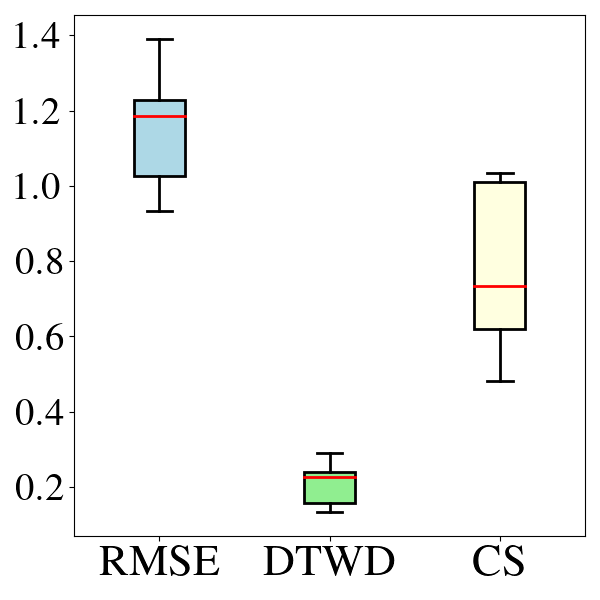

In [12]:
data = [rmse_log.cpu(), dtw_log.cpu()*100, cos_log.cpu()*10]
green_diamond = dict(markerfacecolor='g', marker='D')

# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True

# Set Times as the font family
plt.rcParams['font.family'] = 'Times'

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Customize the box plot
boxprops = dict(linewidth=2, color='black', facecolor='lightgray')
medianprops = dict(linewidth=2, color='red')
whiskerprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
flierprops = green_diamond

boxplot = ax.boxplot(data, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops,
           capprops=capprops, flierprops=flierprops, patch_artist=True)

# Define a list of colors
colors = ['lightblue', 'lightgreen', 'lightyellow']

# Add color to the box plot elements
for patch, color in zip(boxplot['boxes'], colors):
    # Change the fill color of the boxes
    patch.set_facecolor(color)

# Customize the x-axis ticks and labels
plt.xticks([1, 2, 3], ['RMSE', 'DTWD', 'CS'], fontsize=32)
plt.yticks(fontsize=28)
# plt.xlabel('Metrics')

# Add a title and y-axis label if needed
# plt.title('Comparison of Metrics')
# plt.ylabel('Metric Values')

# Adjust the plot layout if needed
plt.tight_layout()

fig.savefig('../outputs/evaluation_learning.png', format='png', dpi=300, bbox_inches="tight")